In [24]:
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import porter
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from scipy.sparse import vstack
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve

In [124]:
def nlp70():
    pos_text = []
    neg_text = []
    with codecs.open("rt-polaritydata/rt-polarity.pos", "rb") as file:
        for i in file:
            pos_text.append("+1 " + str(i.strip()))
    with codecs.open("rt-polaritydata/rt-polarity.neg", "rb") as file:
        for i in file:
            neg_text.append("-1 " + str(i.strip()))
    with codecs.open("sentiment.txt", "w") as file:
        count = 0
        for sentence in np.random.permutation(pos_text + neg_text):
            if count % 100 == 0:
                print(count)
            count+=1
            file.write(sentence.replace("\\",'') + "\n")
    print("finished")
    
if __name__ == "__main__":
    nlp70()
    neg_count = 0
    pos_count = 0
    with codecs.open("sentiment.txt", "r", encoding="utf-8") as file:
        for i in file:
            if i.split()[0] == "-1":
                neg_count += 1
            else:
                pos_count += 1
    print("pos:", pos_count, "neg:", neg_count)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
finished
pos: 5331 neg: 5331


In [11]:
stop = set(stopwords.words("english"))
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [32]:
def nlp71(text):
    stop = set(stopwords.words("english"))
    if any([wd in stop for wd in text.split()]):
        return 1
    else:
        return 0
    
if __name__ == "__main__":
    assert nlp71("I have a pen") == 1
    assert nlp71("hot water") == 0

In [12]:
stemmer = porter.PorterStemmer()

In [13]:
def nlp72(texts, ct):
    """
    polarity = [stemmer.stem(wd) for wd in ["best","frustrat","fun","good",
               "disappointing","fascinating","beautiful",
               "fine","roller-coaster","amateur","bad",
               "worst","terrible","fabulous","great",
               "funny","boring","tired","real",
                "interesting","amusing","nice",
                "emotional","better","worse","enjoy",
               "love","wondering","?","endeavor",
                "charming","fail","success","creative",
                "well","must-see","trash","cry",
                "dream","hell","magic","but"]]
    """
    stop = set(stopwords.words("english"))
    result = []
    for text in tqdm(texts):
        wd_ls = [stemmer.stem(wd) for wd in text.split()]
        wd_ls = " ".join(np.asarray(wd_ls)[np.invert(np.in1d(wd_ls, stop))])
        result.append(ct.transform([wd_ls]))
    return vstack(result)

if __name__ == "__main__":
    ct = CountVectorizer(min_df=0, max_df=0.8)
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        texts = file.readlines()
        texts = [str(" ".join(s.split()[1:]))[2:] for s in texts]
    ct.fit(texts)
    print(nlp72(["I have a pen", "this movie is good"], ct))

100%|██████████| 2/2 [00:00<00:00, 1151.49it/s]

  (0, 7460)	1
  (0, 11717)	1
  (1, 7002)	1
  (1, 8682)	1
  (1, 16326)	1


In [14]:
def nlp73(lab_texts, ct):
    lr = LogisticRegression()
    ans = np.where(np.asarray([text.split()[0] for text in lab_texts]) == "+1", 1, 0)
    lab_texts = [re.sub(r"\W\s", " ", text) for text in lab_texts]
    pol_vecs = nlp72([str(" ".join(s.split()[1:]))[2:] for s in lab_texts], ct)
    lr.fit(pol_vecs, ans)
    print(lr.score(pol_vecs, ans))
    return lr

if __name__ == "__main__":
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        lab_texts = file.readlines()
    nlp73(lab_texts, ct)

100%|██████████| 10662/10662 [00:04<00:00, 2212.38it/s]


0.87835302945


In [281]:
def nlp74(text, lr, ct):
    wd_ls = ct.transform([text])
    return lr.predict(wd_ls), max(lr.predict_proba(wd_ls))

if __name__ == "__main__":
    print(nlp74("It is the best movie that i have ever seen", lr, ct))
    print(nlp74("I've never seen such a terrile movie", lr, ct))
    print(nlp74("I am very hungy", lr, ct))

(array([1]), array([ 0.49018767,  0.50981233]))
(array([0]), array([ 0.93073715,  0.06926285]))
(array([1]), array([ 0.39263868,  0.60736132]))


In [273]:
def nlp75(texts, ct):
    lr = nlp73(texts, ct)
    worst = np.argsort(np.abs(lr.coef_)).flatten()[:10]
    worst = np.asarray(ct.get_feature_names())[worst]
    best = np.argsort(np.abs(lr.coef_)).flatten()[-10:]
    best = np.asarray(ct.get_feature_names())[best]
    return best, worst
if __name__ == "__main__":
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        texts = file.readlines()
    print(nlp74(texts, ct))

100%|██████████| 10662/10662 [00:06<00:00, 1730.54it/s]


0.67698368036
(array(['00', 'photograph', 'photographer', 'photographic', 'photographs',
       'photography', 'photos', 'phrase', 'physical', 'physically'], 
      dtype='<U19'), array(['instead', 'no', 'little', 'yet', 'unfortunately', 'comes', 'bad',
       'plays', 'feels', 'too'], 
      dtype='<U19'))


In [17]:
def nlp76(lab_texts, lr, ct):
    ans = np.asarray([s.split()[0] for s in lab_texts] )
    ans = np.where(ans == "+1", 1, 0)
    texts = [s.split()[1] for s in lab_texts]
    result = []
    for an, text in zip(ans, texts):
        wd_ls = ct.transform([text])
        result.append(str(an) + "\t" + str(lr.predict(wd_ls)[0]) + "\t" + \
            str(np.max(lr.predict_proba(wd_ls))))
    return result

if __name__ == "__main__":
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        texts = file.readlines()
        texts = [s.split()[0] + " " + str(" ".join(s.split()[1:]))[2:] for s in texts]
    lr = nlp73(texts, ct)
    for i in nlp76(texts, lr, ct):
        print(i)

100%|██████████| 10662/10662 [00:05<00:00, 2122.25it/s]


0.871881448134
1	0	0.536632683355
1	1	0.671950521967
0	0	0.519388358313
1	1	0.532331766477
0	0	0.523535997235
0	1	0.555942310301
1	0	0.539364257905
1	0	0.657952572892
1	0	0.587056488937
0	0	0.573384468836
1	0	0.503032728248
0	0	0.539364257905
1	0	0.548179703848
0	0	0.513571660713
1	0	0.539364257905
1	0	0.539364257905
0	0	0.536632683355
0	0	0.536632683355
1	1	0.514464188041
0	0	0.539364257905
0	0	0.539364257905
0	0	0.552486971684
1	0	0.536632683355
0	0	0.536632683355
1	0	0.539364257905
1	1	0.563849712729
1	1	0.634033403419
0	0	0.536632683355
1	0	0.513571660713
0	1	0.505673542948
1	0	0.523251313774
0	0	0.539364257905
0	0	0.539364257905
1	0	0.539364257905
0	0	0.550980881188
0	0	0.633385247548
0	1	0.534801647346
0	0	0.539364257905
1	1	0.529770367806
0	0	0.539364257905
0	0	0.539364257905
1	1	0.534801647346
1	1	0.532331766477
0	0	0.679230476739
1	0	0.539364257905
0	0	0.536632683355
1	0	0.671549691807
1	0	0.536632683355
1	0	0.539364257905
1	0	0.539364257905
0	0	0.539364257905
0	0	0.5393642579

0	0	0.536632683355
1	0	0.536632683355
1	0	0.539364257905
1	0	0.539364257905
1	0	0.539364257905
0	0	0.536632683355
1	0	0.539364257905
1	1	0.569629173882
0	0	0.591795714798
0	0	0.539364257905
1	0	0.548179703848
0	1	0.525996570846
0	0	0.593999209771
1	0	0.519635831577
1	0	0.732104077666
1	0	0.536632683355
0	0	0.539364257905
0	0	0.539364257905
0	0	0.513571660713
0	0	0.585708944221
1	0	0.539364257905
1	0	0.539364257905
0	0	0.838321372612
0	0	0.513571660713
0	0	0.56045904929
0	0	0.539364257905
0	0	0.572583278042
1	0	0.539364257905
0	1	0.516645836106
1	0	0.539364257905
1	0	0.539364257905
1	0	0.536632683355
1	0	0.539364257905
0	0	0.657145394935
1	0	0.583841812107
1	0	0.539364257905
0	0	0.584863119465
1	0	0.539364257905
0	0	0.539364257905
1	0	0.585582679896
1	0	0.550588310002
1	0	0.608272261532
1	0	0.539364257905
1	0	0.539364257905
1	0	0.539364257905
1	0	0.539364257905
0	1	0.529220161125
1	0	0.539364257905
1	0	0.539364257905
1	1	0.525996570846
1	0	0.539364257905
1	1	0.753300423024
1	1	0.5144641

1	0	0.539364257905
1	0	0.539364257905
1	0	0.539364257905
1	0	0.536632683355
1	0	0.598559928206
1	0	0.661114069899
1	0	0.539364257905
1	0	0.536632683355
1	0	0.584863119465
1	0	0.589465867822
1	0	0.536632683355
0	0	0.523251313774
1	0	0.539364257905
0	0	0.513571660713
1	0	0.539364257905
1	0	0.536632683355
0	0	0.549436099328
0	0	0.523251313774
0	0	0.580972708622
0	0	0.595771659863
0	0	0.523251313774
0	0	0.539364257905
0	0	0.549436099328
1	0	0.539364257905
1	0	0.622041599444
1	0	0.539364257905
1	0	0.539364257905
0	0	0.539364257905
1	0	0.539364257905
0	0	0.539364257905
0	0	0.539364257905
0	0	0.770320187876
1	1	0.671950521967
1	1	0.525996570846
0	0	0.539364257905
0	0	0.657952572892
0	1	0.514464188041
0	0	0.539364257905
0	0	0.552486971684
0	0	0.539364257905
0	0	0.539364257905
1	1	0.671950521967
1	0	0.539364257905
0	0	0.539364257905
1	0	0.539364257905
0	0	0.562491183138
0	0	0.536632683355
0	0	0.579049579358
0	0	0.539364257905
1	0	0.539364257905
1	1	0.555942310301
0	0	0.539364257905
1	1	0.701784

1	0	0.513571660713
0	0	0.536632683355
0	0	0.678154815865
0	0	0.513571660713
0	0	0.539364257905
1	1	0.514464188041
0	0	0.539364257905
0	0	0.523251313774
0	0	0.536632683355
0	0	0.622622964649
1	0	0.523251313774
0	0	0.539364257905
0	0	0.734283479252
1	0	0.513571660713
0	0	0.536632683355
1	0	0.539364257905
1	1	0.709320694523
1	0	0.572583278042
1	0	0.539364257905
1	0	0.5849108272
1	0	0.566061794689
1	0	0.536632683355
0	1	0.514520300617
0	1	0.517882810805
1	0	0.513571660713
1	0	0.536632683355
0	0	0.523251313774
0	0	0.513571660713
1	0	0.539364257905
0	0	0.600474215454
0	1	0.517882810805
0	0	0.539364257905
1	0	0.539364257905
0	1	0.553872458644
0	1	0.554629534967
1	0	0.536632683355
1	0	0.539364257905
1	1	0.517882810805
1	0	0.536632683355
1	0	0.536632683355
1	0	0.536632683355
1	1	0.523729618401
0	0	0.634146000923
0	1	0.514464188041
1	0	0.584863119465
0	0	0.539364257905
0	0	0.539364257905
0	0	0.536632683355
0	0	0.513571660713
1	1	0.555942310301
0	0	0.5849108272
0	0	0.539364257905
1	0	0.5393642579

0	0	0.539364257905
1	1	0.565323317818
1	0	0.539364257905
1	0	0.539364257905
1	0	0.536632683355
0	0	0.560041230783
0	0	0.539364257905
1	0	0.536632683355
0	0	0.536632683355
1	0	0.639858509937
0	0	0.591795714798
1	0	0.539364257905
1	0	0.539364257905
1	0	0.536632683355
0	1	0.6393718763
0	0	0.539364257905
1	0	0.539364257905
1	0	0.563472311208
1	1	0.514464188041
0	1	0.665997239828
0	0	0.536632683355
1	1	0.671950521967
0	0	0.536632683355
0	0	0.536632683355
0	0	0.539364257905
1	0	0.591795714798
1	0	0.513571660713
1	0	0.536632683355
1	1	0.517882810805
0	1	0.669838394199
1	1	0.546905669075
0	0	0.513571660713
1	0	0.513571660713
1	1	0.539835683975
1	1	0.514464188041
1	1	0.582606418621
0	1	0.671950521967
1	0	0.539364257905
0	1	0.500849099201
1	0	0.601750714035
1	0	0.539364257905
1	0	0.539364257905
0	0	0.648597634786
0	0	0.539364257905
1	0	0.539364257905
1	0	0.563784899339
0	1	0.517882810805
1	0	0.622622964649
0	1	0.514464188041
0	0	0.539364257905
0	0	0.539364257905
0	0	0.523251313774
0	0	0.53936425

In [18]:
def nlp77(lab_texts, lr, ct):
    result = nlp76(lab_texts, lr, ct)
    acc = np.sum([res.split()[0] == res.split()[1] for res in result]) / len(result)
    pre = np.sum([(res.split()[0] == "1" and res.split()[1] == "1") for res in result]) / \
            sum([res.split()[1] == "1" for res in result])
    recall = np.sum([(res.split()[0] == "1" and res.split()[1] == "1") for res in result]) / \
            sum([res.split()[0] == "1" for res in result])
    f1 = 2 * recall * pre / (recall + pre)
    return acc, pre, recall, f1

if __name__ == "__main__":
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        texts = file.readlines()
        texts = [s.split()[0] + " " + str(" ".join(s.split()[1:]))[2:] for s in texts]
    lr = nlp73(texts, ct)
    print(nlp77(texts, lr, ct))

100%|██████████| 10662/10662 [00:04<00:00, 2174.85it/s]


0.871881448134
(0.52138435565559937, 0.57037037037037042, 0.17332583005064717, 0.26586102719033233)


In [11]:
result = nlp76(texts, lr, ct)
np.sum([(res.split()[1] == "1" and res.split()[0] == "1") for res in result])

924

In [16]:
np.sum([res.split()[1] == "1" for res in result])

1620

In [22]:
def nlp78(lab_texts, ct):
    lab_texts = np.asarray(lab_texts)
    kf = KFold(n_splits=5)
    acc_ls = []
    pre_ls = []
    rec_ls = []
    f1_ls = []
    for train_ind, text_ind in kf.split(lab_texts):
        train_lab_texts = lab_texts[train_ind]
        train_texts = [s.split()[0] + " " + str(" ".join(s.split()[1:]))[2:] \
                       for s in train_lab_texts]
        test_lab_texts = lab_texts[test_ind]
        lr = nlp73(train_lab_texts, ct)
        acc, pre, rec, f1 = nlp77(test_lab_texts, lr, ct)
        acc_ls.append(acc)
        pre_ls.append(pre)
        rec_ls.append(rec)
        f1_ls.append(f1)
    return np.mean(acc_ls), np.mean(pre_ls), np.mean(rec_ls), np.mean(f1_ls)

if __name__ == "__main__":
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        texts = file.readlines()
        texts = [s.split()[0] + " " + str(" ".join(s.split()[1:]))[2:] for s in texts]
    print(nlp78(texts, ct))

100%|██████████| 8529/8529 [00:03<00:00, 2203.88it/s]


0.882870207527


100%|██████████| 8529/8529 [00:03<00:00, 2265.31it/s]


0.877945831868


100%|██████████| 8530/8530 [00:03<00:00, 2166.43it/s]


0.884759671747


100%|██████████| 8530/8530 [00:03<00:00, 2255.43it/s]


0.886518171161


100%|██████████| 8530/8530 [00:04<00:00, 2104.40it/s]


0.884407971864
(0.52397298818232974, 0.57444730110429565, 0.20302860347728552, 0.29637741828576658)


 15%|█▍        | 472/3199 [00:00<00:01, 2358.32it/s]

0.889454642905


100%|██████████| 3199/3199 [00:01<00:00, 2237.20it/s]


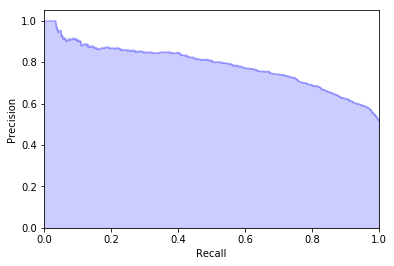

None


In [27]:
def nlp79(lab_texts, ct):
    np.random.shuffle(lab_texts)
    train_lab_texts = lab_texts[:int(len(lab_texts) * 0.7 )]
    test_lab_texts = lab_texts[int(len(lab_texts) * 0.7 ):]
    lr = nlp73(train_lab_texts, ct)
    y_test = np.where(np.asarray([text.split()[0] for text in test_lab_texts]) == "+1", 1, 0)
    y_score = lr.decision_function(nlp72([str(" ".join(s.split()[1:]))[2:] for s in test_lab_texts], ct))
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
if __name__ == "__main__":
    with open("sentiment.txt", "r", encoding="utf-8") as file:
        texts = file.readlines()
        texts = [s.split()[0] + " " + str(" ".join(s.split()[1:]))[2:] for s in texts]
    print(nlp79(texts, ct))